# Computational Experiments

### Imports

In [1]:
import numpy as np
from scipy.linalg import lu

In [2]:
import sys
import os

In [3]:
import cvxpy as cp
import mosek

In [4]:
# Import helper functions from Matrices.py and NormOptimization.py
import Matrices as mat
import NormOptimization as Nopt

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Configurations

In [6]:
eps = np.finfo(float).eps
rows = 40 # rows
cols = 30 # columns

# Setting the pseudorandom number generator
np.random.seed(1)

### Experiments

#### Design

1. 0-99: Tridiagonal matrices (bandwidth=1)
2. 100-199: Pentadiagonal matrices (bandwidth=2)
3. 200-299: Septadiagonal matrices (bandwidth=3)
4. 300-399: Band matrices with bandwidth=4
5. 400-499: Toeplitz matrices with bandwidth=3

In [7]:
# Generating band matrices with random values from the uniform distribution

Exp = {}

for i in range(500):
    if i<100:
        A = mat.RandomBand(rows, cols, band=1) * 0.01
    elif i<200:
        A = mat.RandomBand(rows, cols, band=2) * 0.01
    elif i<300:
        A = mat.RandomBand(rows, cols, band=3) * 0.01
    elif i<400:
        A = mat.RandomBand(rows, cols, band=4) * 0.01
    else:
        A = mat.RandomToeplitzBand(rows, cols, band=2) * 0.01
    Matrix_dict = {}
    Matrix_dict['A'] = A
    Exp[i] = Matrix_dict

In [8]:
# Calculating the Moore-Penrose Pseudoinverse for each band matrix generated

for i in range(500):
    Exp[i]['MPP'] = mat.regularize(np.linalg.pinv(Exp[i]['A']))
    Exp[i]['PLU'] = mat.regularize(mat.PLUginv(Exp[i]['A']))

In [9]:
for i in range(500):
    A = Exp[i]['A']
    MPP = Exp[i]['MPP']
    PLU = Exp[i]['PLU']
    if not np.allclose(A@MPP@A, A, atol=1e-06):
        print(i,"MPP not proper.")
    if not np.allclose(A@PLU@A, A, atol=1e-06):
        print(i,"PLU not proper.")

In [10]:
count_failed=0
Matrices_failed = []
Norm_solving=""
for i in range(500):
    try:
        A = Exp[i]['A']
        Norm_solving="L1"
        x, prob = Nopt.get_Lp(A, lp=1, condns=[1])
        Lp_dict = {}
        Lp_dict['x'], Lp_dict['prob'] = x, prob
        Exp[i]['L1']= Lp_dict

        Norm_solving="Poly"
        x1, prob1 = Nopt.get_weighted_norm(A, weight_type='poly', pw=2, lp=1)
        Poly_dict = {}
        Poly_dict['x'], Poly_dict['prob'] = x1, prob1
        Exp[i]['Poly'] = Poly_dict

        Norm_solving="BigNo"
        x2, prob2 = Nopt.get_weighted_norm(A, weight_type='large', bandwidth=2,penalty=100, lp=1)
        BigNo_dict = {}
        BigNo_dict['x'], BigNo_dict['prob'] = x2, prob2
        Exp[i]['BigNo'] = BigNo_dict

    except cp.SolverError as e:
        count_failed+=1
        print(f"{count_failed}. Solver failed for {i},{Norm_solving}")
        if i not in Matrices_failed:
            Matrices_failed.append(i)
        continue

1. Solver failed for 38,BigNo
2. Solver failed for 66,L1
3. Solver failed for 70,BigNo
4. Solver failed for 85,BigNo
5. Solver failed for 116,BigNo
6. Solver failed for 126,L1
7. Solver failed for 190,Poly
8. Solver failed for 401,L1
9. Solver failed for 410,Poly
10. Solver failed for 425,L1
11. Solver failed for 428,L1
12. Solver failed for 431,L1
13. Solver failed for 449,L1
14. Solver failed for 473,Poly
15. Solver failed for 474,L1


In [37]:
Matrices_failed

[38, 66, 70, 85, 116, 126, 190, 401, 410, 425, 428, 431, 449, 473, 474]

In [38]:
mat_count = []
for i in range(500):
    if i not in Matrices_failed + [424]:
        mat_count.append(i)

In [39]:
MPP_lst = [Exp[i]['MPP'] for i in mat_count]
PLU_lst = [Exp[i]['PLU'] for i in mat_count]
L1_lst = [mat.regularize(Exp[i]['L1']['x'].value) for i in mat_count]
Poly_lst = [mat.regularize(Exp[i]['Poly']['x'].value) for i in mat_count]
BigNo_lst = [mat.regularize(Exp[i]['BigNo']['x'].value) for i in mat_count]

In [62]:
SummStats = {}

SummStats['Matrix #'] = mat_count
def mat_type(i):
    if i<100: return 1
    if i<200: return 2
    if i<300: return 3
    if i<400: return 4
    else: return 5
SummStats['Matrix Group'] = [mat_type(i) for i in mat_count]

SummStats['MPPShape'] = [str(x.shape) for x in MPP_lst]
SummStats['PLUShape'] = [str(x.shape) for x in PLU_lst]
SummStats['L1Shape'] = [str(x.shape) for x in L1_lst]
SummStats['PolyShape'] = [str(x.shape) for x in Poly_lst]
SummStats['BigNoShape'] = [str(x.shape) for x in BigNo_lst]

SummStats['MPP_l0'] = [np.linalg.norm(x.flatten(),0) for x in MPP_lst]
SummStats['PLU_l0'] = [np.linalg.norm(x.flatten(),0) for x in PLU_lst]
SummStats['L1_l0'] = [np.linalg.norm(x.flatten(),0) for x in L1_lst]
SummStats['Poly_l0'] = [np.linalg.norm(x.flatten(),0) for x in Poly_lst]
SummStats['BigNo_l0'] = [np.linalg.norm(x.flatten(),0) for x in BigNo_lst]

SummStats['MPP_l1'] = [np.linalg.norm(x.flatten(),1) for x in MPP_lst]
SummStats['PLU_l1'] = [np.linalg.norm(x.flatten(),1) for x in PLU_lst]
SummStats['L1_l1'] = [np.linalg.norm(x.flatten(),1) for x in L1_lst]
SummStats['Poly_l1'] = [np.linalg.norm(x.flatten(),1) for x in Poly_lst]
SummStats['BigNo_l1'] = [np.linalg.norm(x.flatten(),1) for x in BigNo_lst]

SummStats['MPP_l2'] = [np.linalg.norm(x.flatten(),2) for x in MPP_lst]
SummStats['PLU_l2'] = [np.linalg.norm(x.flatten(),2) for x in PLU_lst]
SummStats['L1_l2'] = [np.linalg.norm(x.flatten(),2) for x in L1_lst]
SummStats['Poly_l2'] = [np.linalg.norm(x.flatten(),2) for x in Poly_lst]
SummStats['BigNo_l2'] = [np.linalg.norm(x.flatten(),2) for x in BigNo_lst]

SummStats['MPP_fro'] = [np.linalg.norm(x,'fro') for x in MPP_lst]
SummStats['PLU_fro'] = [np.linalg.norm(x,'fro') for x in PLU_lst]
SummStats['L1_fro'] = [np.linalg.norm(x,'fro') for x in L1_lst]
SummStats['Poly_fro'] = [np.linalg.norm(x,'fro') for x in Poly_lst]
SummStats['BigNo_fro'] = [np.linalg.norm(x,'fro') for x in BigNo_lst]

In [64]:
# Sparsity and Frobenius norm ratio

SummStats['l0_ratio_PLU'] = [SummStats['PLU_l0'][i]/SummStats['MPP_l0'][i] for i in range(len(SummStats['PLU_l0']))]
SummStats['l0_ratio_L1'] = [SummStats['L1_l0'][i]/SummStats['MPP_l0'][i] for i in range(len(SummStats['L1_l0']))]
SummStats['l0_ratio_Poly'] = [SummStats['Poly_l0'][i]/SummStats['MPP_l0'][i] for i in range(len(SummStats['Poly_l0']))]
SummStats['l0_ratio_BigNo'] = [SummStats['BigNo_l0'][i]/SummStats['MPP_l0'][i] for i in range(len(SummStats['BigNo_l0']))]

SummStats['fro_ratio_PLU'] = [SummStats['PLU_fro'][i]/SummStats['MPP_fro'][i] for i in range(len(SummStats['PLU_fro']))]
SummStats['fro_ratio_L1'] = [SummStats['L1_fro'][i]/SummStats['MPP_fro'][i] for i in range(len(SummStats['L1_fro']))]
SummStats['fro_ratio_Poly'] = [SummStats['Poly_fro'][i]/SummStats['MPP_fro'][i] for i in range(len(SummStats['Poly_fro']))]
SummStats['fro_ratio_BigNo'] = [SummStats['BigNo_fro'][i]/SummStats['MPP_fro'][i] for i in range(len(SummStats['BigNo_fro']))]

In [66]:
Data = {}
matrix_group = SummStats['Matrix Group']
Data['Matrix Number'] = mat_count*4
Data['Matrix Group'] = matrix_group*4

Data['Sparsity Ratio'] = SummStats['l0_ratio_PLU'] + SummStats['l0_ratio_L1'] + SummStats['l0_ratio_Poly'] + SummStats['l0_ratio_BigNo']
Data['Frobenius Ratio'] = SummStats['fro_ratio_PLU'] + SummStats['fro_ratio_L1'] + SummStats['fro_ratio_Poly'] + SummStats['fro_ratio_BigNo']
Data['g-inv Type'] = (['PLU']*484) + (['L1']*484) + (['Poly']*484) + (['Big #']*484)

In [67]:
df_t = pd.DataFrame.from_dict(Data)

,Matrix Number,Matrix Group,Sparsity Ratio,Frobenius Ratio,g-inv Type
0,0,1,0.936559,1.002854,PLU
1,1,1,0.967742,1.063345,PLU
2,2,1,0.967742,1.007327,PLU
3,3,1,0.967742,1.003509,PLU
4,4,1,0.877419,1.071749,PLU


In [72]:
compression_opts = dict(method='zip', archive_name='df_t.csv')  
df_fullrank.to_csv('df_t.zip', index=False, compression=compression_opts)  

In [61]:
df_fullrank = pd.DataFrame.from_dict(SummStats)
compression_opts = dict(method='zip', archive_name='out.csv')  
df_fullrank.to_csv('out.zip', index=False, compression=compression_opts)  

In [54]:
df_fullrank_upd = pd.read_excel('df_fullrank.xls')
#column_names = [col for col in df_fullrank_upd.columns]

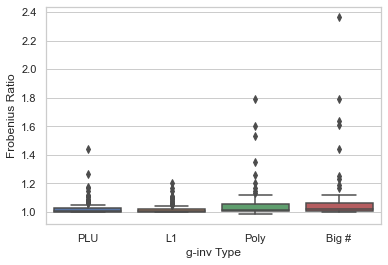

In [97]:
#boxplot = df_fullrank_upd.boxplot(column=['sparsity_ratio_PLU'], by='matrix_group')

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Frobenius Ratio", data=df_t[df_t["Matrix Group"]==1])
plt.savefig("G1Fro.png")

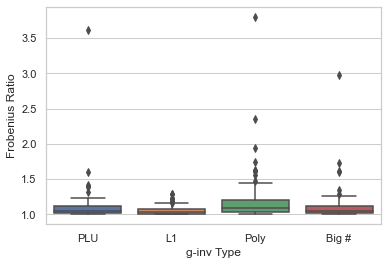

In [98]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Frobenius Ratio", data=df_t[df_t["Matrix Group"]==2])
plt.savefig("G2Fro.png")

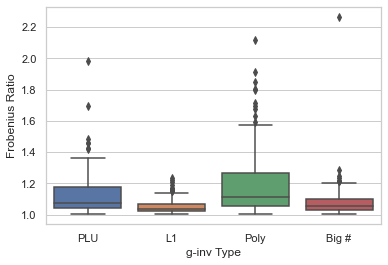

In [99]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Frobenius Ratio", data=df_t[df_t["Matrix Group"]==3])
plt.savefig("G3Fro.png")

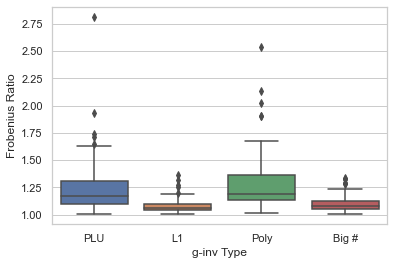

In [100]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Frobenius Ratio", data=df_t[df_t["Matrix Group"]==4])
plt.savefig("G4Fro.png")

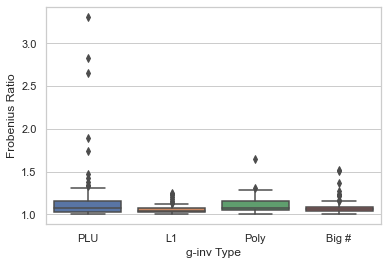

In [101]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Frobenius Ratio", data=df_t[df_t["Matrix Group"]==5])
plt.savefig("G5Fro.png")

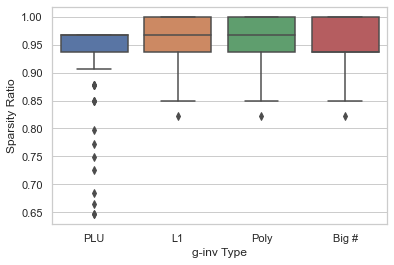

In [112]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Sparsity Ratio", data=df_t[df_t["Matrix Group"]==1])
plt.savefig("G1Sp.png")

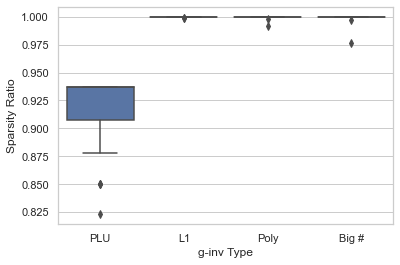

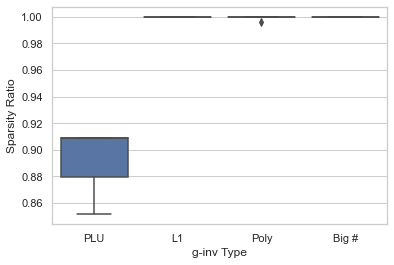

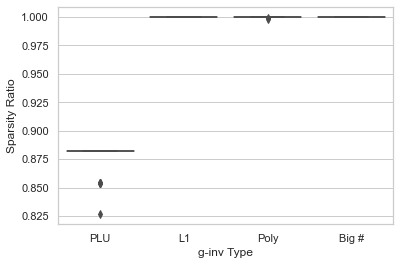

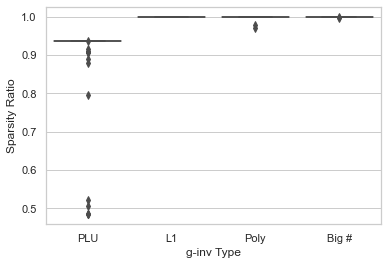

In [113]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Sparsity Ratio", data=df_t[df_t["Matrix Group"]==2])
plt.savefig("G2Sp.png")

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Sparsity Ratio", data=df_t[df_t["Matrix Group"]==3])
plt.savefig("G3Sp.png")

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Sparsity Ratio", data=df_t[df_t["Matrix Group"]==4])
plt.savefig("G4Sp.png")

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sns.boxplot(x="g-inv Type", y="Sparsity Ratio", data=df_t[df_t["Matrix Group"]==5])
plt.savefig("G5Sp.png")

In [158]:
matrix_group_level = np.tile(np.array(matrix_group), 69*5)
matrix_group_level.shape

(166980,)

In [150]:
diag_max_MPP   = np.array([mat.maxdiag(x) for x in MPP_lst])
diag_max_PLU   = np.array([mat.maxdiag(x) for x in PLU_lst])
diag_max_L1    = np.array([mat.maxdiag(x) for x in L1_lst])
diag_max_Poly  = np.array([mat.maxdiag(x) for x in Poly_lst])
diag_max_BigNo = np.array([mat.maxdiag(x) for x in BigNo_lst])

In [151]:
dMPP_flat = diag_max_MPP.flatten('F')
dPLU_flat = diag_max_PLU.flatten('F')
dL1_flat = diag_max_L1.flatten('F')
dPoly_flat = diag_max_Poly.flatten('F')
dBigNo_flat = diag_max_BigNo.flatten('F')

In [183]:
Max_diags = np.concatenate((dMPP_flat, dPLU_flat, dL1_flat, dPoly_flat, dBigNo_flat))
x_coord = np.tile(np.repeat(np.arange(-29,40),484),5)
ginv_type = np.concatenate((np.repeat("MPP",484*69), np.repeat("PLU",484*69), 
                            np.repeat("L1",484*69), np.repeat("Poly",484*69),
                            np.repeat("Big #",484*69)))
test = np.column_stack((matrix_group_level, x_coord, Max_diags))
test.shape

(166980, 3)

In [185]:
diagdf = pd.DataFrame(data=test, columns=['Matrix Group','Diagonal','Value'])
diagdf.dtypes
diagdf['g-inv'] = list(ginv_type)

<ipython-input-190-f34ffd4db908>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.lineplot(data = diagdf[diagdf['Matrix Group']==1][diagdf['g-inv']!='PLU'], x="Diagonal", y="Value", hue="g-inv")


<AxesSubplot:xlabel='Diagonal', ylabel='Value'>

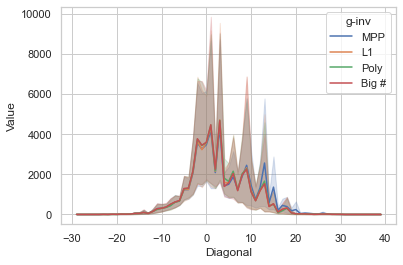

In [190]:
sns.lineplot(data = diagdf[diagdf['Matrix Group']==1], x="Diagonal", y="Value", hue="g-inv")

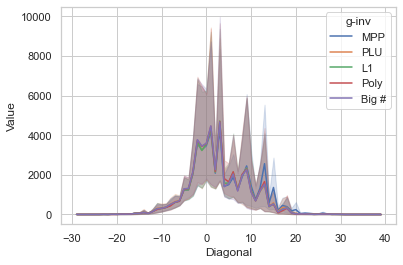

In [191]:
fig, ax = plt.subplots()
ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==1], x="Diagonal", y="Value", hue="g-inv")
plt.savefig('Diag1.png')

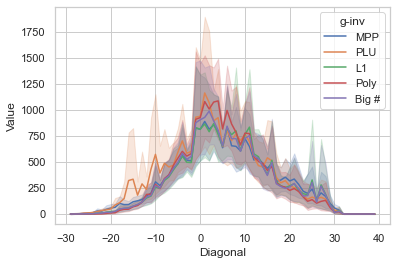

In [192]:
fig, ax = plt.subplots()
ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==2], x="Diagonal", y="Value", hue="g-inv")
plt.savefig('Diag2.png')

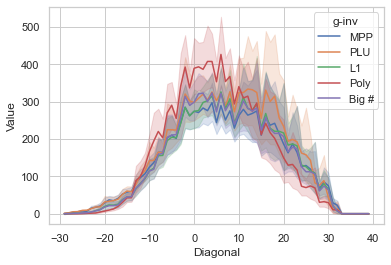

In [193]:
fig, ax = plt.subplots()
ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==3], x="Diagonal", y="Value", hue="g-inv")
plt.savefig('Diag3.png')

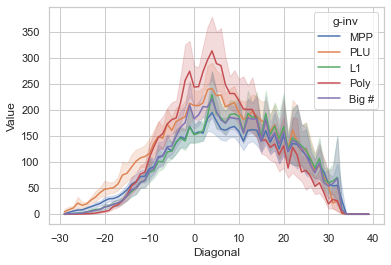

In [194]:
fig, ax = plt.subplots()
ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==4], x="Diagonal", y="Value", hue="g-inv")
plt.savefig('Diag4.png')

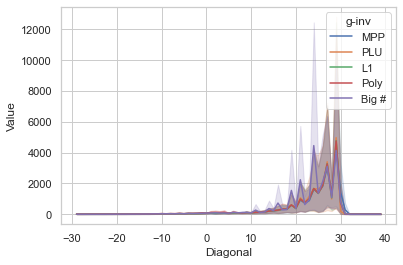

In [195]:
fig, ax = plt.subplots()
ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==5], x="Diagonal", y="Value", hue="g-inv")
plt.savefig('Diag5.png')

<ipython-input-196-afc84f9fa908>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==4][diagdf['g-inv'].isin(['MPP','Poly','Big #'])],


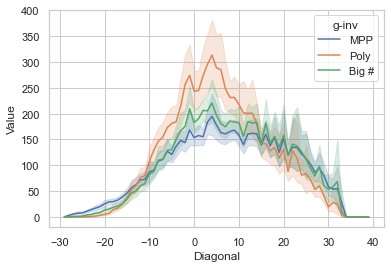

In [196]:
fig, ax = plt.subplots()
ax = sns.lineplot(data = diagdf[diagdf['Matrix Group']==4][diagdf['g-inv'].isin(['MPP','Poly','Big #'])], 
                  x="Diagonal", y="Value", hue="g-inv")
plt.savefig('Diag6.png')

[]

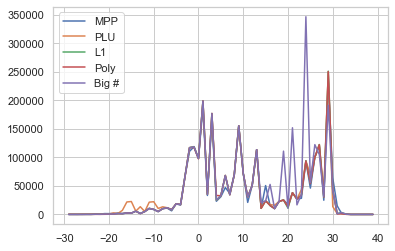

In [124]:
plt.plot(x_coord, np.amax(diag_max_MPP,axis=0), label='MPP')
plt.plot(x_coord, np.amax(diag_max_PLU,axis=0), label='PLU')
plt.plot(x_coord, np.amax(diag_max_L1,axis=0), label='L1')
plt.plot(x_coord, np.amax(diag_max_Poly,axis=0), label='Poly')
plt.plot(x_coord, np.amax(diag_max_BigNo,axis=0), label='Big #')

plt.legend()
plt.plot()